In [1]:
!pip install gensim


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.2156 - loss: -5.4468 - val_accuracy: 0.2022 - val_loss: -22.0410
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.2359 - loss: -21.6157 - val_accuracy: 0.2079 - val_loss: -30.5138
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.2395 - loss: -29.7500 - val_accuracy: 0.2079 - val_loss: -38.4695
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.2453 - loss: -34.7911 - val_accuracy: 0.2079 - val_loss: -45.8187
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.2222 - loss: -43.7321 - val_accuracy: 0.2079 - val_loss: -53.4169
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


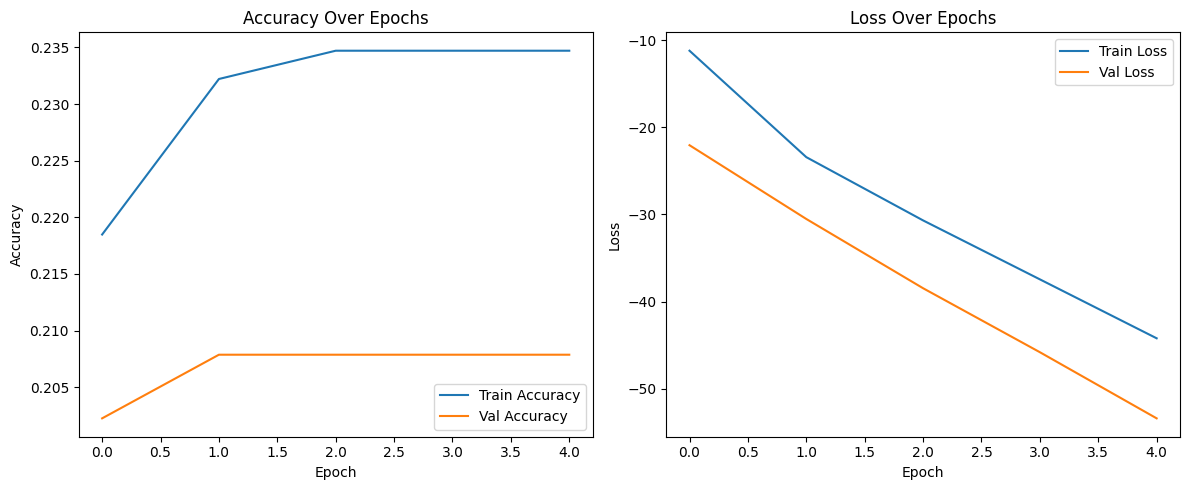

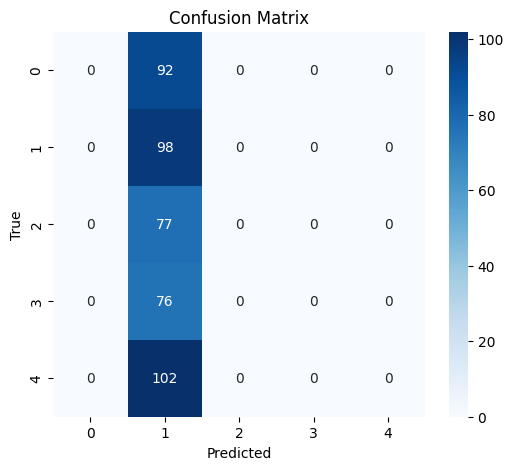

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        92
           1       0.22      1.00      0.36        98
           2       0.00      0.00      0.00        77
           3       0.00      0.00      0.00        76
           4       0.00      0.00      0.00       102

    accuracy                           0.22       445
   macro avg       0.04      0.20      0.07       445
weighted avg       0.05      0.22      0.08       445



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
# Install required packages
!pip install gensim tensorflow seaborn

# Imports
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Load dataset
df = pd.read_csv("/content/df_file.csv")

# Text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df['clean_text'] = df['Text'].apply(preprocess_text)
texts = df['clean_text'].tolist()
labels = df['Label'].tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

# Padding
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Word2Vec training
tokenized_texts = [text.split() for text in texts]
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1)

# Embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(np.array(X_train), np.array(y_train), epochs=5, batch_size=32, validation_split=0.1)

# Predict
y_pred = model.predict(np.array(X_test))
y_pred_labels = (y_pred > 0.5).astype(int)

# Plot Accuracy & Loss
def plot_accuracy_loss(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Run Plots
plot_accuracy_loss(history)
plot_confusion_matrix(y_test, y_pred_labels, class_labels=label_encoder.classes_)

# Optional: Print classification report
print(classification_report(y_test, y_pred_labels))
